In [27]:
!pip install --upgrade pip
!pip install scikit-image>=0.18.0
!pip install scikit-learn>=1.0.0

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import os
import glob
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms

In [29]:
np.random.seed(42)
random.seed(42)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [31]:
# Configuration class for hyperparameters and paths
class Config:
    # Multi-scale approach for robustness
    SCALES = [0.3, 0.4, 0.5, 0.6]  # Multiple scales for better detection
    PATCH_SIZE = 224     # Standard input size for CNN models
    BATCH_SIZE = 16      # Batch size for training
    EPOCHS = 20          # Number of training epochs (reduced for demo)
    LEARNING_RATE = 1e-4 # Learning rate for optimization

    # Sea lion class names for better organization
    CLASS_NAMES = ['adult_males', 'subadult_males', 
                   'adult_females', 'juveniles', 'pups']
    N_CLASSES = 5

    # Data paths - adjust according to your data location
    DATA_ROOT_KAGGLE = "/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/KaggleNOAASeaLions"
    DATA_ROOT_LOCAL = "data"  # Local data folder

    # Check which data directory exists
    if os.path.exists(DATA_ROOT_KAGGLE):
        DATA_ROOT = DATA_ROOT_KAGGLE
    elif os.path.exists(DATA_ROOT_LOCAL):
        DATA_ROOT = DATA_ROOT_LOCAL
    else:
        # Fallback: create dummy directories if no data found
        print("Warning: Data directories not found. Will use dummy data.")
        DATA_ROOT = "data_not_found"
        os.makedirs(os.path.join(DATA_ROOT, "Train"), exist_ok=True)
        os.makedirs(os.path.join(DATA_ROOT, "TrainDotted"), exist_ok=True)
        # Create empty mismatch file
        with open(os.path.join(DATA_ROOT, "MismatchedTrainImages.txt"), 'w') as f:
            pass

    # Define data subdirectories
    TRAIN_DIR = os.path.join(DATA_ROOT, "Train")
    TRAIN_DOTTED_DIR = os.path.join(DATA_ROOT, "TrainDotted")
    MISMATCH_FILE = os.path.join(DATA_ROOT, "MismatchedTrainImages.txt")
    TEST_DIR = os.path.join(DATA_ROOT, "Test")

config = Config()
print(f"Configuration loaded. Data root: {config.DATA_ROOT}")
print(f"Using scales: {config.SCALES}, Patch size: {config.PATCH_SIZE}, Epochs: {config.EPOCHS}")

Configuration loaded. Data root: /kaggle/input/noaa-fisheries-steller-sea-lion-population-count/KaggleNOAASeaLions
Using scales: [0.3, 0.4, 0.5, 0.6], Patch size: 224, Epochs: 20


In [32]:
# PyTorch Dataset class for sea lion data
class SeaLionDataset(Dataset):
    """
    Custom Dataset class for sea lion counting data
    Handles loading and transforming image patches with corresponding count labels
    """
    def __init__(self, X, y, transform=None):
        """
        Initialize dataset
        Args:
            X: numpy array of image patches
            y: numpy array of count labels
            transform: optional data transformation pipeline
        """
        if len(X.shape) == 4 and X.shape[-1] == 3:  # Check if channels-last
            X = np.transpose(X, (0, 3, 1, 2))  # Convert to channels-first
        
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.transform = transform
        
    def __getitem__(self, idx):
        sample = self.X[idx]
        target = self.y[idx]
        
        # Apply transforms if provided
        if self.transform:
            # Convert from CHW to HWC for PIL transforms
            sample_pil = transforms.ToPILImage()(sample)
            sample = self.transform(sample_pil)
        
        return sample, target
        
        return sample, target
    
    def __len__(self):
        return len(self.X)


# Create data transformation pipelines
def create_data_transforms():
    """
    Create training and validation data transformation pipelines
    Returns:
        train_transform: augmentation pipeline for training
        val_transform: normalization pipeline for validation
    """
    # Training transforms with data augmentation
    train_transform = transforms.Compose([
        transforms.RandomRotation(45),      # Random rotation up to 45 degrees
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomVerticalFlip(),    # Random vertical flip
        transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Color variations
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406],       # ImageNet normalization
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

print("Dataset class and transforms defined.")

Dataset class and transforms defined.


In [33]:
# Enhanced data processing function for sea lion detection
def enhanced_get_data(filename, scale=0.4, patch_size=224):
    """
    Process sea lion images to extract patches and count labels
    
    Args:
        filename: name of the image file
        scale: scale factor for image resizing
        patch_size: size of extracted patches
        
    Returns:
        X: array of image patches
        y: array of count labels per patch
    """
    try:
        # Construct file paths
        image_dotted_path = os.path.join(config.TRAIN_DOTTED_DIR, filename)
        image_original_path = os.path.join(config.TRAIN_DIR, filename)

        # Check if both files exist
        if not os.path.exists(image_dotted_path) or not os.path.exists(image_original_path):
            return None, None

        # Load images
        image_dotted = cv2.imread(image_dotted_path)
        image_original = cv2.imread(image_original_path)

        if image_dotted is None or image_original is None:
            return None, None

        # Apply Gaussian blur to dotted image for better dot detection
        img_blurred = cv2.GaussianBlur(image_dotted, (5, 5), 0)
        
        # Calculate difference between dotted and original images
        diff = cv2.absdiff(image_dotted, image_original)
        
        # Create mask to isolate dots
        mask_gray = cv2.cvtColor(image_dotted, cv2.COLOR_BGR2GRAY)
        mask_bin = np.zeros_like(mask_gray)
        mask_bin[mask_gray > 20] = 255  # Threshold for dot detection
        
        # Apply mask to difference image
        masked_diff = cv2.bitwise_or(diff, diff, mask=mask_bin)
        gray_diff = np.max(masked_diff, axis=2)

        # Detect blobs (sea lions) using Laplacian of Gaussian
        blobs = skimage.feature.blob_log(
            gray_diff, min_sigma=2, max_sigma=7, num_sigma=3, threshold=0.01
        )

        # Calculate grid dimensions based on scale and patch size
        h, w, _ = image_original.shape
        grid_w_count = int(np.ceil((w * scale) / patch_size))
        grid_h_count = int(np.ceil((h * scale) / patch_size))
        
        # Initialize result grid for counts per class
        result_grid = np.zeros((grid_h_count, grid_w_count, config.N_CLASSES), dtype='float32')

        # Process each detected blob
        for blob in blobs:
            y, x, sigma = map(int, blob)
            if 0 <= y < h and 0 <= x < w:
                # Get BGR values at blob location
                b_val, g_val, r_val = img_blurred[y, x]
                
                # Calculate grid indices
                grid_x_idx = min(int((x * scale) // patch_size), grid_w_count - 1)
                grid_y_idx = min(int((y * scale) // patch_size), grid_h_count - 1)

                # Classify sea lion type based on color
                cl = -1
                if r_val > 200 and g_val < 50 and b_val < 50:
                    cl = 0  # Adult Males (Red dots)
                elif r_val > 200 and g_val < 50 and b_val > 200:
                    cl = 1  # Subadult Males (Magenta dots)
                elif r_val < 50 and g_val > 150 and b_val < 50:
                    cl = 2  # Adult Females (Green dots)
                elif r_val < 50 and g_val < 50 and b_val > 150:
                    cl = 3  # Juveniles (Blue dots)
                elif r_val > 60 and r_val < 120 and g_val < 75 and b_val < 50:
                    cl = 4  # Pups (Brown dots)

                # Increment count for detected class
                if cl != -1:
                    result_grid[grid_y_idx, grid_x_idx, cl] += 1

        # Create mask for valid regions (exclude very dark areas)
        valid_region_mask = (np.sum(image_dotted, axis=2) > 10).astype('uint8')
        valid_region_mask_bgr = cv2.cvtColor(valid_region_mask * 255, cv2.COLOR_GRAY2BGR)
        
        # Apply mask to original image
        processed_img_masked = image_original * (valid_region_mask_bgr // 255)

        # Resize image according to scale
        processed_img_resized = cv2.resize(processed_img_masked, (int(w * scale), int(h * scale)))
        processed_img_normalized = processed_img_resized.astype('float32') / 255.0

        # Extract patches from processed image
        h_new, w_new, _ = processed_img_normalized.shape
        patches_x, patches_y = [], []

        for r_idx in range(grid_h_count):
            for c_idx in range(grid_w_count):
                # Calculate patch boundaries
                y_start, y_end = r_idx * patch_size, (r_idx + 1) * patch_size
                x_start, x_end = c_idx * patch_size, (c_idx + 1) * patch_size

                # Ensure boundaries are within image
                y_end = min(y_end, h_new)
                x_end = min(x_end, w_new)

                # Skip if patch start is outside image
                if y_start >= h_new or x_start >= w_new:
                    continue

                # Extract patch
                patch = processed_img_normalized[y_start:y_end, x_start:x_end, :]
                actual_h, actual_w, _ = patch.shape

                # Pad patch if smaller than target size
                if actual_h < patch_size or actual_w < patch_size:
                    pad_h = patch_size - actual_h
                    pad_w = patch_size - actual_w
                    patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), 
                                 mode='constant', constant_values=0)

                # Add patch and corresponding label if correct size
                if patch.shape == (patch_size, patch_size, 3):
                    patches_x.append(patch)
                    patches_y.append(result_grid[r_idx, c_idx, :])

        if patches_x:
            patches_array = np.array(patches_x)
            if patches_array.shape[-1] == 3:
                patches_array = np.transpose(patches_array, (0, 3, 1, 2))
            
            return patches_array, np.array(patches_y)
        
        return None, None

    except Exception as e:
        print(f"Error processing {filename} at scale {scale}: {e}")
        return None, None

# PyTorch loss function
def custom_rmse_loss(y_pred, y_true):
    """
    Custom Root Mean Square Error loss function
    Args:
        y_pred: predicted values
        y_true: true values
    Returns:
        RMSE loss
    """
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def rmse(y_true, y_pred):
    """
    Calculate RMSE using numpy
    Args:
        y_true: true values
        y_pred: predicted values
    Returns:
        RMSE value
    """
    return np.sqrt(np.mean((y_true - y_pred)**2))

print("Data processing functions defined.")


Data processing functions defined.


In [34]:
# PyTorch model architectures
class EnhancedCNN(nn.Module):
    """
    Enhanced CNN architecture for sea lion counting
    Multi-layer convolutional network with batch normalization and dropout
    """
    def __init__(self, input_channels=3, num_classes=5):
        super(EnhancedCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third convolutional block
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)
        
        # Fully connected layers
        self.flatten_size = 128 * (224 // 8) * (224 // 8)  # Calculate flattened size
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)  # Output layer for regression
        
    def forward(self, x):
        """
        Forward pass through the network
        Args:
            x: input tensor
        Returns:
            output tensor
        """
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third convolutional block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)  # Linear output for regression
        
        return x

class VGGTransfer(nn.Module):
    """
    VGG16-based transfer learning model for sea lion counting
    Uses pre-trained VGG16 features with custom classifier
    """
    def __init__(self, num_classes=5):
        super(VGGTransfer, self).__init__()
        
        # Load pre-trained VGG16 model
        self.vgg = models.vgg16(pretrained=True)
        
        # Freeze feature extraction layers
        for param in self.vgg.features.parameters():
            param.requires_grad = False

        num_features = self.vgg.classifier[0].in_features
        
        # Replace classifier with custom regression head
        self.vgg.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 1024),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)   # Linear output for regression
        )
        
    def forward(self, x):
        """
        Forward pass through VGG transfer model
        Args:
            x: input tensor
        Returns:
            output tensor
        """
        if x.dim() == 3:
            x = x.unsqueeze(0)
        
        return self.vgg(x)

print("Model architectures defined.")

Model architectures defined.


In [35]:
# Training data loading function
def load_training_data(max_files=2, scales=None):
    """
    Load and process training data from sea lion images
    
    Args:
        max_files: maximum number of files to process (for demo)
        scales: list of scale factors to apply
        
    Returns:
        X: processed image patches
        y: corresponding count labels
    """
    if scales is None:
        scales = config.SCALES

    # Load list of mismatched files to exclude
    bad_files = set()
    if os.path.exists(config.MISMATCH_FILE):
        try:
            with open(config.MISMATCH_FILE, 'r') as f:
                bad_files = set(line.strip() for line in f if line.strip())
        except Exception as e:
            print(f"Could not read mismatch file: {e}")

    # Get list of available image files
    all_image_files = []
    if os.path.exists(config.TRAIN_DIR):
        all_image_files = [f for f in os.listdir(config.TRAIN_DIR)
                          if f.endswith('.jpg') and f not in bad_files]
        random.shuffle(all_image_files)  # Shuffle for variety

    # Create dummy data if no real data found
    if not all_image_files:
        print("No training image files found. Using dummy data.")
        dummy_X = np.random.rand(32, config.PATCH_SIZE, config.PATCH_SIZE, 3).astype('float32')
        dummy_y = np.random.randint(0, 2, (32, config.N_CLASSES)).astype('float32')
        return dummy_X, dummy_y

    # Limit number of files for processing
    files_to_process = all_image_files[:max_files] if max_files else all_image_files
    print(f"Loading data from {len(files_to_process)} files, scales: {scales}")

    # Process files at different scales
    X_all, y_all = [], []
    for scale_val in tqdm.tqdm(scales, desc="Processing Scales"):
        for filename in tqdm.tqdm(files_to_process, desc=f"Scale {scale_val} Files", leave=False):
            X_batch, y_batch = enhanced_get_data(filename, scale=scale_val, patch_size=config.PATCH_SIZE)
            if X_batch is not None and len(X_batch) > 0:
                X_all.extend(X_batch)
                y_all.extend(y_batch)

    # Create dummy data if no patches extracted
    if not X_all:
        print("No patches extracted from available files. Using dummy data.")
        dummy_X = np.random.rand(32, config.PATCH_SIZE, config.PATCH_SIZE, 3).astype('float32')
        dummy_y = np.random.randint(0, 2, (32, config.N_CLASSES)).astype('float32')
        return dummy_X, dummy_y

    X = np.array(X_all)
    y = np.array(y_all)

    print(f"Data loading complete. Total patches: {len(X)}")
    if len(X) > 0:
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        print(f"y distribution (sum per class): {np.sum(y, axis=0)}")
    return X, y

print("Training data loading function defined.")

Training data loading function defined.


In [36]:
# PyTorch training function
def train_model_pytorch(model, train_loader, val_loader, model_name="model", epochs=2, lr=1e-4):
    """
    Train PyTorch model with validation
    
    Args:
        model: PyTorch model to train
        train_loader: training data loader
        val_loader: validation data loader
        model_name: name for saving model
        epochs: number of training epochs
        lr: learning rate
        
    Returns:
        trained model and training history
    """
    model.to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = custom_rmse_loss
    
    # Track best validation loss for model saving
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    print(f"\nTraining {model_name}... Input shape: {next(iter(train_loader))[0].shape}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Zero gradients, forward pass, compute loss, backward pass, update
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            print(f"Saved best model for {model_name}")
    
    return model, {'train_loss': train_losses, 'val_loss': val_losses}

# Model evaluation function
def evaluate_model_performance(model, test_loader, model_name="model"):
    """
    Evaluate model performance on test data
    
    Args:
        model: trained PyTorch model
        test_loader: test data loader
        model_name: model name for reporting
        
    Returns:
        dictionary with evaluation metrics
    """
    model.eval()
    y_true_all = []
    y_pred_all = []
    
    # Collect predictions and ground truth
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            y_true_all.extend(target.cpu().numpy())
            y_pred_all.extend(output.cpu().numpy())
    
    y_true = np.array(y_true_all)
    y_pred_raw = np.array(y_pred_all)
    
    # Post-processing: clip negative values and apply threshold
    y_pred_processed = np.clip(y_pred_raw, 0, None)
    y_pred_thresholded = y_pred_processed * (y_pred_processed > 0.3)
    
    # Calculate RMSE metrics
    rmse_processed = rmse(y_true, y_pred_processed)
    rmse_thresholded = rmse(y_true, y_pred_thresholded)
    
    print(f"\n--- {model_name} Evaluation Results ---")
    print(f"RMSE (Processed): {rmse_processed:.4f}")
    print(f"RMSE (Processed and Thresholded): {rmse_thresholded:.4f}")
    
    return {
        'rmse': rmse_processed,
        'rmse_thresholded': rmse_thresholded,
        'predictions': y_pred_processed
    }

# Training history visualization
def plot_training_summary(history, model_name):
    """
    Plot training and validation loss curves
    
    Args:
        history: training history dictionary
        model_name: model name for plot title
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


In [37]:
def validate_input_dimensions(data_loader, model_name="model"):
    """
    Validate input tensor dimensions before training
    """
    for batch_idx, (data, target) in enumerate(data_loader):
        print(f"{model_name} - Batch {batch_idx}:")
        print(f"  Input shape: {data.shape}")  # Supposed to be [batch_size, 3, 224, 224]
        print(f"  Target shape: {target.shape}")  # Supposed to be [batch_size, 5]
        
        # Dimension
        if len(data.shape) != 4:
            raise ValueError(f"Expected 4D input tensor, got {len(data.shape)}D")
        if data.shape[1] != 3:
            raise ValueError(f"Expected 3 channels, got {data.shape[1]} channels")
        if data.shape[2] != 224 or data.shape[3] != 224:
            raise ValueError(f"Expected 224x224 images, got {data.shape[2]}x{data.shape[3]}")
            
        break 


In [38]:
# Main training pipeline
def run_main_pipeline():
    """
    Execute the complete sea lion counting pipeline
    Includes data loading, model training, evaluation, and ensemble creation
    
    Returns:
        trained models, evaluation results, and test data
    """
    print("=== Starting Sea Lion Counting Pipeline (PyTorch) ===")

    # Step 1: Load training data
    print("\n--- Step 1: Loading Training Data ---")
    X, y = load_training_data(max_files=config.EPOCHS, scales=config.SCALES[:1])

    if X is None or len(X) == 0:
        print("Critical error: No training data loaded. Exiting pipeline.")
        return {}, {}, None, None

    # Ensure sufficient data for training
    if len(X) < config.BATCH_SIZE * 2:
        print(f"Warning: Very few samples ({len(X)}). Duplicating data for stability.")
        factor = (config.BATCH_SIZE * 2) // len(X) + 1
        X = np.concatenate([X] * factor, axis=0)
        y = np.concatenate([y] * factor, axis=0)
        print(f"Augmented sample count to {len(X)}")

    # Step 2: Split data into train/validation/test sets
    print("\n--- Step 2: Splitting Data ---")
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, random_state=42)
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    # Step 3: Create data loaders with transforms
    train_transform, val_transform = create_data_transforms()
    
    train_dataset = SeaLionDataset(X_train, y_train, transform=train_transform)
    val_dataset = SeaLionDataset(X_val, y_val, transform=val_transform)
    test_dataset = SeaLionDataset(X_test, y_test, transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    validate_input_dimensions(train_loader, "Training")
    validate_input_dimensions(val_loader, "Validation")
    
    trained_models = {}
    evaluation_results = {}

    # Step 4: Train Enhanced CNN model
    print("\n--- Step 3: Training Enhanced CNN ---")
    try:
        cnn_model = EnhancedCNN(input_channels=3, num_classes=config.N_CLASSES)
        cnn_model, cnn_history = train_model_pytorch(
            cnn_model, train_loader, val_loader, "Enhanced_CNN", 
            epochs=config.EPOCHS, lr=config.LEARNING_RATE)
        trained_models["Enhanced_CNN"] = cnn_model
        evaluation_results["Enhanced_CNN"] = evaluate_model_performance(
            cnn_model, test_loader, "Enhanced_CNN")
        plot_training_summary(cnn_history, "Enhanced_CNN")
    except Exception as e:
        print(f"Error training Enhanced CNN: {e}")

    # Step 5: Train VGG16 Transfer Learning model
    print("\n--- Step 4: Training VGG16 Transfer Model ---")
    try:
        vgg_model = VGGTransfer(num_classes=config.N_CLASSES)
        vgg_model, vgg_history = train_model_pytorch(
            vgg_model, train_loader, val_loader, "VGG16_Transfer", 
            epochs=config.EPOCHS, lr=config.LEARNING_RATE)
        trained_models["VGG16_Transfer"] = vgg_model
        evaluation_results["VGG16_Transfer"] = evaluate_model_performance(
            vgg_model, test_loader, "VGG16_Transfer")
        plot_training_summary(vgg_history, "VGG16_Transfer")
    except Exception as e:
        print(f"Error training VGG16 model: {e}")

    # Step 6: Create ensemble predictions if multiple models trained
    if len(trained_models) > 1:
        print("\n--- Step 5: Creating Ensemble Predictions ---")
        ensemble_preds_list = []
        
        # Collect predictions from all trained models
        for model_name, model_instance in trained_models.items():
            if model_name in evaluation_results and 'predictions' in evaluation_results[model_name]:
                ensemble_preds_list.append(evaluation_results[model_name]['predictions'])

        if ensemble_preds_list:
            # Average ensemble predictions
            avg_ensemble_pred = np.mean(ensemble_preds_list, axis=0)
            avg_ensemble_pred_thresholded = avg_ensemble_pred * (avg_ensemble_pred > 0.3)

            # Calculate ensemble metrics
            ensemble_rmse_val = rmse(y_test, avg_ensemble_pred)
            ensemble_rmse_thresh_val = rmse(y_test, avg_ensemble_pred_thresholded)

            print(f"Ensemble (Average) RMSE (Processed): {ensemble_rmse_val:.4f}")
            print(f"Ensemble (Average) RMSE (Processed & Thresholded): {ensemble_rmse_thresh_val:.4f}")
            
            evaluation_results["Ensemble_Average"] = {
                'rmse': ensemble_rmse_val, 
                'rmse_thresholded': ensemble_rmse_thresh_val, 
                'predictions': avg_ensemble_pred
            }

    # Step 7: Final summary of results
    print("\n=== Pipeline Execution Summary ===")
    if not evaluation_results:
        print("No models were successfully trained or evaluated.")
    else:
        # Display results for all models
        for name, res in evaluation_results.items():
            print(f"{name:>20s}: RMSE (Processed) = {res.get('rmse', float('nan')):.4f}, "
                  f"RMSE (Thresholded) = {res.get('rmse_thresholded', float('nan')):.4f}")

        # Identify best performing model
        best_model_name = min(evaluation_results.items(), 
                            key=lambda x: x[1].get('rmse_thresholded', float('inf')))[0]
        print(f"\nBest performing model (based on thresholded RMSE): {best_model_name}")

    return trained_models, evaluation_results, X_test, y_test

print("Main training pipeline function defined.")

Main training pipeline function defined.


Starting the PyTorch sea lion counting pipeline execution...
Using 20 epochs for training. This is a demo run.
Using device: cuda
=== CUDA Configuration ===
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
CUDNN version: 90300
Number of GPUs: 2
Current GPU: 0
GPU name: Tesla T4
=== Starting Sea Lion Counting Pipeline (PyTorch) ===

--- Step 1: Loading Training Data ---
Loading data from 20 files, scales: [0.3]


Processing Scales: 100%|██████████| 1/1 [04:16<00:00, 256.99s/it][A


Data loading complete. Total patches: 791
X shape: (791, 3, 224, 224), y shape: (791, 5)
y distribution (sum per class): [ 135.   74.  391.    0. 2480.]

--- Step 2: Splitting Data ---
Train: (474, 3, 224, 224), Val: (158, 3, 224, 224), Test: (159, 3, 224, 224)
Training - Batch 0:
  Input shape: torch.Size([16, 3, 224, 224])
  Target shape: torch.Size([16, 5])
Validation - Batch 0:
  Input shape: torch.Size([16, 3, 224, 224])
  Target shape: torch.Size([16, 5])

--- Step 3: Training Enhanced CNN ---

Training Enhanced_CNN... Input shape: torch.Size([16, 3, 224, 224])
Epoch 1/20, Train Loss: 5.1866, Val Loss: 3.9467
Saved best model for Enhanced_CNN
Epoch 2/20, Train Loss: 4.4778, Val Loss: 3.9700
Epoch 3/20, Train Loss: 4.3677, Val Loss: 3.9634
Epoch 4/20, Train Loss: 4.5839, Val Loss: 3.9475
Epoch 5/20, Train Loss: 4.4559, Val Loss: 3.9309
Saved best model for Enhanced_CNN
Epoch 6/20, Train Loss: 4.5847, Val Loss: 3.9111
Saved best model for Enhanced_CNN
Epoch 7/20, Train Loss: 4.2293

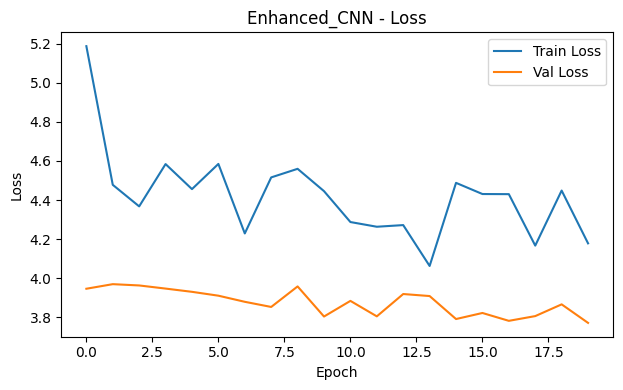


--- Step 4: Training VGG16 Transfer Model ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]  



Training VGG16_Transfer... Input shape: torch.Size([16, 3, 224, 224])
Epoch 1/20, Train Loss: 4.5974, Val Loss: 3.8951
Saved best model for VGG16_Transfer
Epoch 2/20, Train Loss: 3.9683, Val Loss: 3.8145
Saved best model for VGG16_Transfer
Epoch 3/20, Train Loss: 4.3870, Val Loss: 3.8875
Epoch 4/20, Train Loss: 4.0644, Val Loss: 3.7582
Saved best model for VGG16_Transfer
Epoch 5/20, Train Loss: 4.2659, Val Loss: 3.7192
Saved best model for VGG16_Transfer
Epoch 6/20, Train Loss: 3.9834, Val Loss: 3.6786
Saved best model for VGG16_Transfer
Epoch 7/20, Train Loss: 4.1194, Val Loss: 3.6481
Saved best model for VGG16_Transfer
Epoch 8/20, Train Loss: 4.3526, Val Loss: 3.6471
Saved best model for VGG16_Transfer
Epoch 9/20, Train Loss: 4.1376, Val Loss: 3.6325
Saved best model for VGG16_Transfer
Epoch 10/20, Train Loss: 3.7935, Val Loss: 3.6093
Saved best model for VGG16_Transfer
Epoch 11/20, Train Loss: 3.9604, Val Loss: 3.6438
Epoch 12/20, Train Loss: 3.8758, Val Loss: 3.5983
Saved best mod

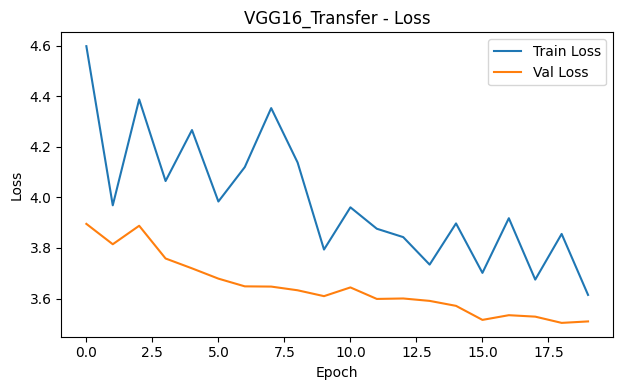


--- Step 5: Creating Ensemble Predictions ---
Ensemble (Average) RMSE (Processed): 6.5058
Ensemble (Average) RMSE (Processed & Thresholded): 6.5070

=== Pipeline Execution Summary ===
        Enhanced_CNN: RMSE (Processed) = 6.6322, RMSE (Thresholded) = 6.6353
      VGG16_Transfer: RMSE (Processed) = 6.4569, RMSE (Thresholded) = 6.4571
    Ensemble_Average: RMSE (Processed) = 6.5058, RMSE (Thresholded) = 6.5070

Best performing model (based on thresholded RMSE): VGG16_Transfer

=== FINAL EXECUTION STATUS ===
Successfully trained 2 model(s): ['Enhanced_CNN', 'VGG16_Transfer']
Saved best model (VGG16_Transfer) as best_overall_model_pytorch.pth
PyTorch pipeline execution finished.


In [39]:
# Execute main pipeline
print("Starting the PyTorch sea lion counting pipeline execution...")
print(f"Using {config.EPOCHS} epochs for training. This is a demo run.")
print(f"Using device: {device}")
# Initialize result containers
trained_models_dict = {}
eval_results_dict = {}
X_test_final, y_test_final = None, None

print("=== CUDA Configuration ===")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDNN version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU name: {torch.cuda.get_device_name()}")


try:
    # Run the complete pipeline
    trained_models_dict, eval_results_dict, X_test_final, y_test_final = run_main_pipeline()

    print("\n=== FINAL EXECUTION STATUS ===")
    if trained_models_dict:
        print(f"Successfully trained {len(trained_models_dict)} model(s): {list(trained_models_dict.keys())}")
        
        # Save the best performing model
        if eval_results_dict:
            best_model_key = min(eval_results_dict, 
                                key=lambda k: eval_results_dict[k].get('rmse_thresholded', float('inf')))
            if best_model_key in trained_models_dict:
                torch.save(trained_models_dict[best_model_key].state_dict(), 
                          "best_overall_model_pytorch.pth")
                print(f"Saved best model ({best_model_key}) as best_overall_model_pytorch.pth")
    else:
        print("No models were trained successfully in this run.")

except Exception as e:
    print(f"A critical error occurred during pipeline execution: {e}")
    import traceback
    traceback.print_exc()
finally:
    print("PyTorch pipeline execution finished.")
